# Callin Switzer
___

### 16 Jan 2020
### - Train without pruning
### - Then prune a Dense, Feedforward Neural Network with Keras
### - Use data that was generated in Python

___

In [32]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
plt.rc('font',family='Times New Roman')
from matplotlib.ticker import ScalarFormatter
import os
import pandas as pd
import time
from datetime import datetime
import sys
import seaborn as sns
import scipy.io
import subprocess
import winsound
import pickle
import glob
import sqlite3

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
print("TensorFlow successfully installed.")
if tf.test.is_built_with_cuda():
    print("The installed version of TensorFlow includes GPU support.")
print(sys.version, "\n")
now = datetime.now()
print("last run on " + str(now))

# define directories
baseDir = os.getcwd()
dataDir = r'D:\MothSimulations\11c-AggressiveManeuver\Qstore\hws_am_con'
figDir = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\Figs'
dataOutput = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\DataOutput'
savedModels = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\savedModels'
dataDir = r'D:/Dropbox/AcademiaDropbox/mothMachineLearning_dataAndFigs/PythonGeneratedData_oneTorque/'
if not os.path.exists(figDir):
    os.mkdir(figDir)

if not os.path.exists(dataOutput):
    os.mkdir(dataOutput)
if not os.path.exists(savedModels):
    os.mkdir(savedModels)


TensorFlow successfully installed.
The installed version of TensorFlow includes GPU support.
3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)] 

last run on 2020-01-27 08:46:08.247174


In [2]:
# import
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model
from keras import regularizers

# Keras callcacks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras.backend as K

Using TensorFlow backend.


# Make training and test set

In [3]:
# get table names in database
con1 = sqlite3.connect(os.path.join(dataDir, "oneTorqueData.db"))
cursorObj = con1.cursor()
res = cursorObj.execute("SELECT name FROM sqlite_master WHERE type='table';")
tableNames = [name[0] for name in res]
con1.close()
print(tableNames)

['test', 'train']


In [4]:
con1 = sqlite3.connect(os.path.join(dataDir, "oneTorqueData.db"))
trainDF = pd.read_sql_query("SELECT * FROM train", con1)
testDF = pd.read_sql_query("SELECT * FROM test", con1)
con1.close()

In [5]:
# double check for repeats!
np.sum(trainDF.iloc[:, [16,17,18]].duplicated()) # 0 means no repeats

0

In [6]:
print(trainDF.shape)
trainDF.head()

(10000000, 19)


,x_0,xd_0,y_0,yd_0,theta_0,thetad_0,phi_0,phid_0,x_f,xd_f,y_f,yd_f,theta_f,thetad_f,phi_f,phid_f,F,alpha,tau0
0,0.0,1127.569064,0.0,765.895323,1.075898,11.962440,3.427385,18.462602,18.395120,720.596469,14.991199,564.440206,2.620463,143.757506,5.082561,149.863616,41181.992912,1.987846,-63216.237665
1,0.0,979.651081,0.0,-625.561275,0.306688,-5.637037,2.576453,19.788635,18.621532,880.434302,-13.742423,-731.060427,0.112672,-33.187823,2.382966,-33.150583,9062.020340,3.567122,19108.940596
2,0.0,1111.257777,0.0,-1406.672066,5.094943,16.102668,1.775724,-9.188076,19.014489,1042.106161,-25.204363,-1013.381330,2.863959,-213.548177,-0.317910,-206.678168,42727.993224,4.104033,49781.327507
3,0.0,-1438.730397,0.0,690.882986,5.034187,-3.375327,5.534301,-9.669100,-31.106570,-1508.832101,10.684741,335.455964,6.295325,138.687265,6.771356,137.904931,28953.145279,4.698031,92261.347215
4,0.0,1370.322727,0.0,-216.459775,4.186927,-16.500337,3.194818,-0.385905,27.275396,1358.731404,-4.542652,-238.481028,3.985371,-9.972093,3.182170,-0.693456,371.601599,0.668810,-40259.257246


In [7]:
# rename columns to be consistent with other code
trainDF.rename(columns={"x0" : "x_0", "y0" : "y_0", "phi0" : "phi_0", "theta0" : "theta_0", 
                        "x_f" : "x_99", "y_f" : "y_99", "phi_f" : "phi_99", "theta_f" : "theta_99", 
                        "xd_0" : "x_dot_0", "yd_0" : "y_dot_0", "phid_0" : "phi_dot_0", "thetad_0": "theta_dot_0", 
                        "xd_f" : "x_dot_99", "yd_f": "y_dot_99", "phid_f": "phi_dot_99", "thetad_f": "theta_dot_99", 
                        "tau0" : "tau"}, inplace=True)

# rename columns to be consistent with other code
testDF.rename(columns={"x0" : "x_0", "y0" : "y_0", "phi0" : "phi_0", "theta0" : "theta_0", 
                        "x_f" : "x_99", "y_f" : "y_99", "phi_f" : "phi_99", "theta_f" : "theta_99", 
                        "xd_0" : "x_dot_0", "yd_0" : "y_dot_0", "phid_0" : "phi_dot_0", "thetad_0": "theta_dot_0", 
                        "xd_f" : "x_dot_99", "yd_f": "y_dot_99", "phid_f": "phi_dot_99", "thetad_f": "theta_dot_99", 
                        "tau0" : "tau"}, inplace=True)

In [8]:
# convert to fx and fy
trainDF["Fx"] = trainDF.F * np.cos(trainDF.alpha)
trainDF["Fy"] = trainDF.F * np.sin(trainDF.alpha)

testDF["Fx"] = testDF.F * np.cos(testDF.alpha)
testDF["Fy"] = testDF.F * np.sin(testDF.alpha)


In [9]:
# make dataset
X = trainDF.loc[:, [ "phi_0", "theta_0", 
                    "x_99", "y_99", "phi_99", "theta_99", 
                   "x_dot_0", "y_dot_0", "phi_dot_0", "theta_dot_0"]]

Y = trainDF.loc[:, ["Fx", "Fy", "tau", "x_dot_99", "y_dot_99", 
                    "phi_dot_99", "theta_dot_99"] ]

# make test dataset
Xtest = testDF.loc[:, [ "phi_0", "theta_0", 
                    "x_99", "y_99", "phi_99", "theta_99", 
                   "x_dot_0", "y_dot_0", "phi_dot_0", "theta_dot_0"]]

Ytest = testDF.loc[:, ["Fx", "Fy", "tau", "x_dot_99", "y_dot_99", 
                    "phi_dot_99", "theta_dot_99"] ]

In [10]:
X.head()

,phi_0,theta_0,x_99,y_99,phi_99,theta_99,x_dot_0,y_dot_0,phi_dot_0,theta_dot_0
0,3.427385,1.075898,18.395120,14.991199,5.082561,2.620463,1127.569064,765.895323,18.462602,11.962440
1,2.576453,0.306688,18.621532,-13.742423,2.382966,0.112672,979.651081,-625.561275,19.788635,-5.637037
2,1.775724,5.094943,19.014489,-25.204363,-0.317910,2.863959,1111.257777,-1406.672066,-9.188076,16.102668
3,5.534301,5.034187,-31.106570,10.684741,6.771356,6.295325,-1438.730397,690.882986,-9.669100,-3.375327
4,3.194818,4.186927,27.275396,-4.542652,3.182170,3.985371,1370.322727,-216.459775,-0.385905,-16.500337


In [11]:
Y.head()

,Fx,Fy,tau,x_dot_99,y_dot_99,phi_dot_99,theta_dot_99
0,-16681.383440,37652.197635,-63216.237665,720.596469,564.440206,149.863616,143.757506
1,-8253.874132,-3740.825371,19108.940596,880.434302,-731.060427,-33.150583,-33.187823
2,-24419.876370,-35062.102662,49781.327507,1042.106161,-1013.381330,-206.678168,-213.548177
3,-415.702991,-28950.160838,92261.347215,-1508.832101,335.455964,137.904931,138.687265
4,291.543841,230.412537,-40259.257246,1358.731404,-238.481028,-0.693456,-9.972093


In [12]:
# val train split
Xtrain, Xval, Ytrain, Yval = train_test_split(X, Y, test_size=0.2, random_state = 123)

In [13]:
# scale data 
scalerX = MinMaxScaler([-0.5, 0.5])  
scalerY = MinMaxScaler([-0.5, 0.5])  

# Don't cheat - fit only on training data
scalerX.fit(Xtrain)  
scalerY.fit(Ytrain) 

Xtrain_scaled = scalerX.transform(Xtrain)  
Ytrain_scaled = scalerY.transform(Ytrain)  

# apply same transformation to test data
Xval_scaled = scalerX.transform(Xval)
Yval_scaled = scalerY.transform(Yval)


# final test data
Xtest_scaled = scalerX.transform(Xtest)

In [14]:
pd.DataFrame(Xtrain_scaled, columns = X.columns).head()

,phi_0,theta_0,x_99,y_99,phi_99,theta_99,x_dot_0,y_dot_0,phi_dot_0,theta_dot_0
0,0.440808,-0.497541,-0.377559,-0.093133,0.279853,-0.127880,-0.413733,-0.087276,0.151751,-0.419563
1,0.002656,0.450960,0.232459,0.301555,-0.029443,0.182687,0.276074,0.383212,0.227138,0.094672
2,0.302116,0.217276,0.364897,-0.175870,-0.005774,-0.045649,0.385703,-0.188919,-0.266187,-0.202705
3,-0.471247,0.121804,0.069457,0.309980,-0.318901,-0.060641,0.103501,0.332100,-0.227711,0.447327
4,-0.350056,-0.349031,0.313385,0.159446,-0.094834,-0.093747,0.350805,0.216431,0.136925,0.270457


# Keras models

In [15]:
# import
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model
from keras import regularizers

# Keras callcacks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras.backend as K

K.clear_session()

In [16]:
# create network
def create_network(optimizer = 'rmsprop', 
                    numUnits = [400, 16], 
                    weightRegularization = 0.0, 
                    dropout_rate=0.1):
    
    '''
    Create a feed forward network.  Assumes Xtrain & Ytrain have been created and scaled
    
    Params: 
    optimizer (str): choice of optimizer
    numUnits (list): number of units in each hidden
    weightRegularization (float): between 0 and 1
    dropout_rate (float): between 0 and 1
    
    '''
    K.clear_session()
    inputs = Input(shape=(Xtrain_scaled.shape[1],))    
    
    # add layers
    for ii in np.arange(0, len(numUnits)):
        if ii >= 1: 
            x = Dense(numUnits[ii], activation='tanh', 
                      kernel_regularizer=regularizers.l1(weightRegularization))(x)

        else: 
            x = Dense(numUnits[ii], activation='tanh')(inputs)


        # add dropout
        if dropout_rate > 0: 
            x = Dropout(dropout_rate)(x)
    
    predictions = Dense(Ytrain_scaled.shape[1], activation='linear')(x)

    # create model
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(loss="mean_squared_error", optimizer = optimizer, metrics = ['mse'])

    return(model)

In [17]:
def format_e(n):
    a = '%E' % n
    return a.split('E')[0].rstrip('0').rstrip('.') + 'E' + a.split('E')[1]


earlystop = EarlyStopping(monitor='val_mean_squared_error', patience=150, 
                          verbose=1, mode='auto', min_delta = 0.000001)

In [18]:
def plot_model_history(model_history, saveFig = False):
    fig, axs = plt.subplots(1,1,figsize=(10,5))
    # summarize history for accuracy
    axs.plot(range(1,len(model_history.history['mean_squared_error'])+1),
             model_history.history['mean_squared_error'])
    axs.plot(range(1,len(model_history.history['val_mean_squared_error'])+1),
             model_history.history['val_mean_squared_error'])
    axs.set_title('Model MSE = '+ str(format_e(model_history.history['val_mean_squared_error'][-1])))
    axs.set_ylabel('Mean squared error')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(0,len(model_history.history['val_mean_squared_error']), 50), 50)
    axs.legend(['train', 'validation'], loc='best')
    plt.yscale('log') #logarithmic scale for y axis
    if saveFig:
        fig.savefig(os.path.join(figDir, "ModelTraining_" + modelName + ".pdf"), dpi = 500, bbox_inches='tight')
    
    plt.show()

    
def plot_model_history_fromDict(model_history_dictionary, saveFig = False):
    fig, axs = plt.subplots(1,1,figsize=(10,5))
    # summarize history for accuracy
    axs.plot(range(1,len(model_history_dictionary['mean_squared_error'])+1),
             model_history_dictionary['mean_squared_error'])
    axs.plot(range(1,len(model_history_dictionary['val_mean_squared_error'])+1),
             model_history_dictionary['val_mean_squared_error'])
    axs.set_title('Model MSE = '+ str(format_e(model_history_dictionary['val_mean_squared_error'][-1])) + "\n" +  str(nzwts) + " non-zero weights")
    axs.set_ylabel('mean_squared_error')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(1,len(model_history_dictionary['val_mean_squared_error'])+1),
                   len(model_history_dictionary['val_mean_squared_error'])/10)
    axs.legend(['train', 'validation'], loc='best')
    plt.yscale('log') #logarithmic scale for y axis
    if saveFig:
        fig.savefig(os.path.join(figDir, "ModelTraining_" + modelName + "_pruned.png"), dpi = 120, bbox_inches='tight')
        print(os.path.join(figDir, "ModelTraining_" + modelName + "_pruned.png"))
    plt.show()

___

In [19]:
# train and trim weights

In [20]:

K.clear_session()

modelParams = {"optimizer": "rmsprop", 
              "dropout_rate" : 0, 
               "numUnits": [400, 400, 400, 16],
               "weightRegularization": 0
              }


model = create_network(**modelParams)

modeltimestamp = datetime.now().strftime("%Y_%m_%d__%I_%M_%S")
modelName = ''.join('{}_{}__'.format(key[0:3].capitalize(), val) for  key, val in modelParams.items()).\
                            replace("[", "").replace("]", "").replace(", ", "_")[0:-2] + "_" + modeltimestamp
print(modelName)

model.summary()

Opt_rmsprop__Dro_0__Num_400_400_400_16__Wei_0_2020_01_24__04_40_30
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               4400      
_________________________________________________________________
dense_2 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_3 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_4 (Dense)              (None, 16)                6416      
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 119       
Total params: 331,735
Trainable params: 331,735
Non-trainable params: 0
___

In [21]:
# # save scalers, to be used on test set
scalerfileX = 'scalerX_fullact_' + modeltimestamp + '.pkl'
pickle.dump(scalerX, open(os.path.join(dataOutput, scalerfileX), 'wb'))

scalerfileY = 'scalerY_fullact_' + modeltimestamp + '.pkl'
pickle.dump(scalerY, open(os.path.join(dataOutput, scalerfileY), 'wb'))

In [22]:
# start training
historyDict = {"mean_squared_error": [], 
               "val_mean_squared_error": []}

In [23]:
# train without pruning
history = model.fit(Xtrain_scaled, Ytrain_scaled, 
                    validation_data=(Xval_scaled, Yval_scaled), 
                    callbacks = [earlystop],
                    verbose = 2, batch_size=2**12, epochs = 1000)

Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1000
 - 17s - loss: 0.0158 - mean_squared_error: 0.0158 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 2/1000
 - 15s - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 3/1000
 - 15s - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 4/1000
 - 15s - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 5/1000
 - 15s - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 6/1000
 - 15s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 7/1000
 - 15s - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 8/1000
 - 15s - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 9/1000
 - 15

In [24]:
# save history
historyDict["mean_squared_error"].append(history.history["mean_squared_error"][0])
historyDict["val_mean_squared_error"].append(history.history["val_mean_squared_error"][0])

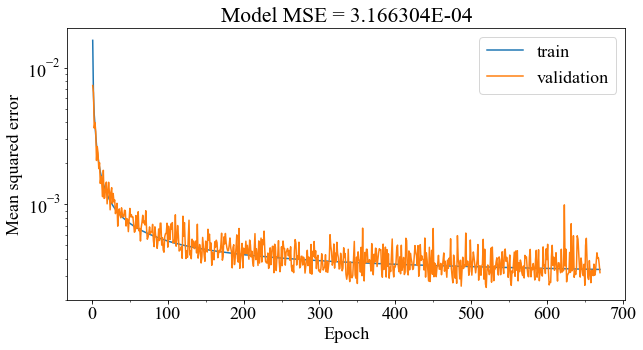

In [25]:
plt.rcParams.update({'font.size': 18})
plot_model_history(history, saveFig=True)

In [26]:
# save model
model.save(os.path.join(savedModels,  modelName + '.h5'))

# save weights
wts = model.get_weights().copy()

wtsFile = modelName + '_wts.pkl'
pickle.dump(wts, open(os.path.join(dataOutput, wtsFile), 'wb'))

# save history with same name as model
historyFile = modeltimestamp + '_history.pkl'
pickle.dump(scalerY, open(os.path.join(dataOutput, scalerfileY), 'wb'))

In [27]:
#  plot error rates on test data

In [ ]:
# predict on test set
Ytest_pred = model.predict(Xtest_scaled)


# make data frames
XtestDF = pd.DataFrame(scalerX.inverse_transform(Xtest_scaled), columns = Xtrain.columns)
YtestDF = pd.DataFrame(Ytest, columns = Ytrain.columns)
YpredDF = pd.DataFrame(scalerY.inverse_transform(Ytest_pred), columns = Ytrain.columns+ "_pred")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

df_c = pd.concat([YtestDF.reset_index(drop=True), YpredDF], axis=1)
df_c.head()


In [29]:
#df_c = df_c.iloc[:1000, :]

# df_c = df_c.replace([np.inf, -np.inf], np.nan)
# df_c = df_c.replace([np.inf, -np.inf], np.nan).dropna()

In [ ]:
import matplotlib.ticker as mtick
import matplotlib
class MathTextSciFormatter(mtick.Formatter):
    def __init__(self, fmt="%1.2e"):
        self.fmt = fmt
    def __call__(self, x, pos=None):
        s = self.fmt % x
        decimal_point = '.'
        positive_sign = '+'
        tup = s.split('e')
        significand = tup[0].rstrip(decimal_point)
        sign = tup[1][0].replace(positive_sign, '')
        exponent = tup[1][1:].lstrip('0')
        if exponent:
            exponent = '10^{%s%s}' % (sign, exponent)
        if significand and exponent:
            s =  r'%s{\times}%s' % (significand, exponent)
        else:
            return(" ")
        return "${}$".format(s)

In [ ]:
# make plots
from sklearn.metrics import r2_score
from matplotlib import ticker
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['mathtext.default'] = 'regular'
import matplotlib.ticker as mtick
plt.rcParams.update({'font.size': 11})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.transforms as mtrans


fig_col_names = [r'$F_x$', r'$F_y$', r'$\tau$', r'$\dot{x}_f$', r'$\dot{y}_f$', r'$\dot{\phi}_f$', r'$\dot{\theta}_f$']

plt.close("all")
fig, axs = plt.subplots(4,4, figsize=np.array([8, 7.5]), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.9, wspace=.9)
# fig.suptitle('Predicted vs. acutal ', fontsize=14, fontweight='bold')

axs = axs.ravel("C")

ylabs = [r'$g·cm/s^2$', "$g·cm/s^2$", "$g·cm^2/s^2$", "$cm/s$", "$cm/s$", "$rad/s$", "$rad/s$"]

# replace lightest colors with white
import matplotlib.colors

cmap = plt.cm.magma_r
cmaplist = np.array([cmap(i) for i in range(cmap.N)])
cmaplist[:,0:3] = np.divide(cmaplist[:, 0:3], 1.1)
cmaplist[0] = (1,1,1,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

# Plot y = actual, x = predicted
for ii in np.arange(0, 3):
    axs[ii].hexbin(y = df_c.loc[:,YtestDF.columns[ii]],
                   x = df_c.loc[:,YpredDF.columns[ii]], 
                   gridsize = 50, cmap = cmap)
    axs[ii].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[ii].yaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[ii].set_yticklabels(axs[ii].get_yticklabels(), 
                            rotation = 45, ha="center",
                            va = "bottom", rotation_mode="anchor")
    axs[ii].yaxis.set_label_coords(-0.4,0.5)
    axs[ii].set_xlabel(ylabs[ii] + "\n")
    axs[ii].xaxis.set_label_coords(0.5,-0.2)
#     axs[ii].set_xticklabels(axs[ii].get_xticklabels(), 
#                            va = "center", rotation_mode="anchor")
    axs[ii].tick_params(axis="x",direction="out", pad=-0)
    

    if(ii == 0):
        axs[ii].set_ylabel("Actual Value\n" + ylabs[ii])
    else:
        axs[ii].set_ylabel(ylabs[ii])

    #axs[ii].set_title(YtestDF.columns[ii])
    axs[ii].set_title(fig_col_names[ii], fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[ii].title
    ttl.set_position([.15, 0.62])
    axs[ii].plot(df_c.loc[:,YtestDF.columns[ii]], 
                 df_c.loc[:,YtestDF.columns[ii]], 
                 'grey', linewidth = 1, linestyle  = "--")
    axs[ii].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[ii].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[ii].set_aspect('equal', 'box')

    # annotate with R^2
    axs[ii].text(np.max(df_c.loc[:,YtestDF.columns[ii]])*-0.4, 
                 np.min(df_c.loc[:,YtestDF.columns[ii]])*0.9, 
                 r'$r^2$ =' + 
                 str(np.round((r2_score(df_c.loc[:,YtestDF.columns[ii]],  
                                        df_c.loc[:,YpredDF.columns[ii]])), 3)))
    axs[ii].set_xlim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]])), 
                      np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]]))])
    axs[ii].set_ylim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]])), 
                  np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]]))])

# # residual plots x = predicted, y = actual - predicted
# jj is column in dataset, plotNum is plot position
for jj, plotNum in enumerate(np.arange(4, 7)):

    axs[plotNum].hexbin(y = df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]],
                   x = df_c.loc[:,YpredDF.columns[jj]], 
                   gridsize = 50, cmap = cmap) 
    axs[plotNum].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotNum].yaxis.set_major_locator(ticker.MaxNLocator(3))  
    axs[plotNum].set_yticklabels(axs[plotNum].get_yticklabels(), 
                                 rotation = 45, ha="center", 
                                 va = "bottom", rotation_mode="anchor")
    axs[plotNum].yaxis.set_label_coords(-0.4,0.5)
    axs[plotNum].xaxis.set_label_coords(0.5,-0.2)
    
    if jj == 3:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n\n" + "                      Predicted Value")
    else:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n")
    axs[plotNum].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotNum].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))

    if(jj == 0):
        axs[plotNum].set_ylabel("Actual - Predicted\n" + ylabs[jj])
    else:
        axs[plotNum].set_ylabel(ylabs[jj])
        
    axs[plotNum].set_title(fig_col_names[jj], fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[plotNum].title
    ttl.set_position([.15, 0.62])

    axs[plotNum].hlines(y = 0, xmin = np.min( df_c.loc[:,YpredDF.columns[jj]]), 
                   xmax = np.max( df_c.loc[:,YpredDF.columns[jj]]), 
                   linestyle =  "--", linewidth = 1)
    axs[plotNum].set_ylim([-np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]])), 
                      np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]]- df_c.loc[:,YpredDF.columns[jj]]))])
    axs[plotNum].tick_params(axis="x",direction="out", pad=-0)
#####
#### Part 2
#####

#fig.subplots_adjust(hspace = 0.9, wspace=.9)

# Plot y = actual, x = predicted
for plotnum, dataColNum in zip(np.arange(8,12), np.arange(3, 7)):
    axs[plotnum].hexbin(y = df_c.loc[:,YtestDF.columns[dataColNum]],
                   x = df_c.loc[:,YpredDF.columns[dataColNum]], 
                   gridsize = 50, cmap = cmap)
    axs[plotnum].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotnum].yaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotnum].set_yticklabels(axs[plotnum].get_yticklabels(),
                                 rotation = 45, ha="center",
                                 va = "bottom", rotation_mode="anchor")
    axs[plotnum].yaxis.set_label_coords(-0.5,0.5)
    axs[plotnum].set_xlabel(ylabs[dataColNum] + "\n")
    axs[plotnum].xaxis.set_label_coords(0.5,-0.2)

    if(plotnum == 8):
        axs[plotnum].set_ylabel("Actual Value\n" + ylabs[dataColNum])
    else:
        axs[plotnum].set_ylabel(ylabs[dataColNum])

    #axs[ii].set_title(YtestDF.columns[ii])
    axs[plotnum].set_title(fig_col_names[dataColNum], 
                           fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[plotnum].title
    ttl.set_position([.15, 0.60])
    axs[plotnum].plot(df_c.loc[:,YtestDF.columns[dataColNum]], 
                 df_c.loc[:,YtestDF.columns[dataColNum]], 
                 'grey', linewidth = 1, linestyle  = "--")
    axs[plotnum].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotnum].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotnum].set_aspect('equal', 'box')

    # annotate with R^2
    axs[plotnum].text(np.max(df_c.loc[:,YtestDF.columns[dataColNum]])*-0.4, 
                 np.min(df_c.loc[:,YtestDF.columns[dataColNum]])*0.85, 
                 r'$r^2$ =' + 
                 str(np.round((r2_score(df_c.loc[:,YtestDF.columns[dataColNum]],  
                                        df_c.loc[:,YpredDF.columns[dataColNum]])), 3)))
    axs[plotnum].set_xlim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]])), 
                      np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]]))])
    axs[plotnum].set_ylim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]])), 
                  np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]]))])
    
    axs[plotnum].tick_params(axis="x",direction="out", pad=-0)

# residual plots x = predicted, y = actual - predicted
# jj is column in dataset, plotNum is plot position
# refref Here
for jj, plotNum in zip(np.arange(3, 7), np.arange(12, 16)):

    axs[plotNum].hexbin(y = df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]],
                   x = df_c.loc[:,YpredDF.columns[jj]], 
                   gridsize = 50, cmap = cmap) 
    axs[plotNum].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotNum].yaxis.set_major_locator(ticker.MaxNLocator(3))  
    axs[plotNum].set_yticklabels(axs[plotNum].get_yticklabels(), 
                                 rotation = 45, ha="center", 
                                 va = "bottom", rotation_mode="anchor")
    axs[plotNum].yaxis.set_label_coords(-0.4,0.5)
    axs[plotNum].xaxis.set_label_coords(0.5,-0.2)
    
    if jj == 4:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n\n" + "                                       Predicted Value")
    else:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n")
    axs[plotNum].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotNum].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))

    if(jj == 3):
        axs[plotNum].set_ylabel("Actual - Predicted\n" + ylabs[jj])
    else:
        axs[plotNum].set_ylabel(ylabs[jj])

    axs[plotNum].hlines(y = 0, xmin = np.min( df_c.loc[:,YpredDF.columns[jj]]), 
                   xmax = np.max( df_c.loc[:,YpredDF.columns[jj]]), 
                   linestyle =  "--", linewidth = 1)
    axs[plotNum].set_ylim([-np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]])), 
                      np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]]- df_c.loc[:,YpredDF.columns[jj]]))])
    
    axs[plotNum].set_title(fig_col_names[jj], fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[plotNum].title
    ttl.set_position([.15, 0.67])
    axs[plotNum].tick_params(axis="x",direction="out", pad=-0)
    

# add black horizontal line
ax3 = plt.figure(1).add_subplot(111)
ax3.plot([-1,1],[0.48,0.48], '-', color = "black" )
ax3.set_xlim([0,1])
ax3.set_ylim([0,1])
ax3.axis("off")

#plt.tight_layout()
fig.savefig(os.path.join(figDir, "PredVActual" + modelName + ".pdf"),)
plt.show()
# plt.close()

In [ ]:
np.arange(4, 7)

In [ ]:
# make plots --- Vertical
from sklearn.metrics import r2_score
from matplotlib import ticker
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['mathtext.default'] = 'regular'
import matplotlib.ticker as mtick
plt.rcParams.update({'font.size': 8})


fig_col_names = [r'$F_x$', r'$F_y$', r'$\tau$', r'$\dot{x}_f$', r'$\dot{y}_f$', r'$\dot{\phi}_f$', r'$\dot{\theta}_f$']

plt.close("all")
fig, axs = plt.subplots(Ytest.shape[1], 2,figsize=np.array([ 3, 22]), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 1.4, wspace=1.5)
# fig.suptitle('Predicted vs. acutal ', fontsize=14, fontweight='bold')

axs = axs.ravel("C")

ylabs = [r'$g·cm/s^2$', "$g·cm/s^2$", "$g·cm^2/s^2$", "$cm/s$", "$cm/s$", "$rad/s$", "$rad/s$"]

# replace lightest colors with white
import matplotlib.colors

cmap = plt.cm.magma_r
cmaplist = np.array([cmap(i) for i in range(cmap.N)])
cmaplist[:,0:3] = np.divide(cmaplist[:, 0:3], 1.1)
cmaplist[0] = (1,1,1,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

# Plot y = actual, x = predicted
for ii, colnum in enumerate(np.arange(0, df_c.shape[1], 2)):
    axs[colnum].hexbin(y = df_c.loc[:,YtestDF.columns[ii]],
                   x = df_c.loc[:,YpredDF.columns[ii]], 
                   gridsize = 50, cmap = cmap)
    axs[colnum].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[colnum].yaxis.set_major_locator(ticker.MaxNLocator(3))

    if(ii == 0):
        axs[colnum].set_title("Actual Value\n")
    
    axs[colnum].set_ylabel(fig_col_names[ii] + "\n" + ylabs[ii])
    axs[colnum].set_xlabel(ylabs[ii])

    #axs[ii].set_title(YtestDF.columns[ii])
#     axs[colnum].set_title(fig_col_names[ii], fontdict = {'verticalalignment': 'bottom'})
    axs[colnum].plot(df_c.loc[:,YtestDF.columns[ii]], 
                 df_c.loc[:,YtestDF.columns[ii]], 
                 'grey', linewidth = 1, linestyle  = "--")
    axs[colnum].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[colnum].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[colnum].set_aspect('equal', 'box')

    # annotate with R^2
    axs[colnum].text(np.max(df_c.loc[:,YtestDF.columns[ii]])*-0.4, 
                 np.min(df_c.loc[:,YtestDF.columns[ii]])*0.9, 
                 r'$r^2$ =' + 
                 str(np.round((r2_score(df_c.loc[:,YtestDF.columns[ii]],  
                                        df_c.loc[:,YpredDF.columns[ii]])), 3)))
    axs[colnum].set_xlim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]])), 
                      np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]]))])
    axs[colnum].set_ylim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]])), 
                  np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]]))])

# # residual plots x = predicted, y = actual - predicted
# jj is column in dataset, plotNum is plot position
for jj, plotNum in enumerate(np.arange(1, df_c.shape[1], 2)):

    axs[plotNum].hexbin(y = df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]],
                   x = df_c.loc[:,YpredDF.columns[jj]], 
                   gridsize = 50, cmap = cmap) 
    axs[plotNum].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotNum].yaxis.set_major_locator(ticker.MaxNLocator(3))  
    
    if jj == 3:
        axs[plotNum].set_xlabel(ylabs[jj])
    else:
        axs[plotNum].set_xlabel(ylabs[jj])
    axs[plotNum].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotNum].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))

    if(jj == 0):
        axs[plotNum].set_title("Actual - Predicted\n")

    axs[plotNum].hlines(y = 0, xmin = np.min( df_c.loc[:,YpredDF.columns[jj]]), 
                   xmax = np.max( df_c.loc[:,YpredDF.columns[jj]]), 
                   linestyle =  "--", linewidth = 1)
    axs[plotNum].set_ylim([-np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]])), 
                      np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]]- df_c.loc[:,YpredDF.columns[jj]]))])


#fig.savefig(os.path.join(figDir, "PredVActual" + modelName + ".pdf"), dpi = 500, bbox_inches='tight')
plt.show()
# plt.close()

In [ ]:
# train with pruning
numCuts = 1

wts = model.get_weights()
wtLengths = []
for ii in range(len(wts)):
    wtLengths.append(np.prod(wts[ii].shape))

In [ ]:
# train until I have very good results
# then prune, and retrain until results are close
# change pruning rate as data get closer to 100% removed
def prune_percent_updater(x):
    logit = np.exp(x*8) / (np.exp(x*8) + 1)
    return((logit - 0.5)*2*50)


# cuts a smaller portion as the percent gets closer to 100%
cutPercent = prune_percent_updater(np.linspace(0, 1, 26))

while True:   
   
    for numEpocs in range(100):
        
        MSE_tmp = []

        history = model.fit(Xtrain_scaled, Ytrain_scaled, validation_split = 0.3, 
                            verbose = 2, batch_size=2**12, epochs = 1)

        
        # save history
        historyDict["mean_squared_error"].append(history.history["mean_squared_error"][0])
        historyDict["val_mean_squared_error"].append(history.history["val_mean_squared_error"][0])
        
        # local MSE
        MSE_tmp.append(history.history["mean_squared_error"][0])

        # set weights that are close to 0 all the way back to 0, and then retrain for one epoch
        # get nonzero weights
        wts = model.get_weights().copy()

        # set weights close to 0 to 0 (but ignore biases)
        for ii in np.arange(0, len(wts), 1):
            qants = np.percentile(np.reshape(wts[ii], -1), q = (50 - cutPercent[numCuts], 50 + cutPercent[numCuts]), )
            wts[ii][(wts[ii] > qants[0]) & (wts[ii] < qants[1])] = 0

        # print nonzero weights
        # calculate number of nonzero weights
        nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
        print(nzwts, "of", np.sum(wtLengths), "weights retained")

        # set new weights and calculate new loss
        model.set_weights(wts)
        
        # check the change in mean squared error, and if it's not changing much, then cut out more data
        # calculate slope of loss, based on previous 5 data points
        if numEpocs > 5:
            inputData = historyDict["mean_squared_error"][-5:]

            m = np.shape(inputData)
            X = np.matrix([np.ones(m), np.arange(0, len(inputData))]).T
            y = np.matrix(np.log(inputData)).T

            # Solve for projection matrix
            intercept, slope = np.array(np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)).reshape(-1,)
            print("change in log loss:", slope)
    
            # break if slope has stopped changing or if the overall min has been surpassed
            # in the first training, it will automatically prune after 5 epochs, because the min will be passed
            if (np.abs(slope) < 0.0001) or (history.history["mean_squared_error"][0] < np.min(historyDict["mean_squared_error"][:-1])): 
                print("************************************************ PRUNING ********************************************************")
                print("************************************************ PRUNING ********************************************************")
                print("************************************************ PRUNING ********************************************************")
                model.save(os.path.join(figDir,  modelName + str(datetime.now())[0:-7].replace("-", "_").replace(" ", "__").replace(":", "_") + '_Pruned.h5'))
                break
                       
                    
    ## refref: may want to save weights before each pruning, so I can go back, if I need to
    ## refref: should I be pruning the biases too?
    
    ## keep running tally of min mse, and if we can't get back to the min, then break
#     print("Min MSE for this prune ", np.min(MSE_tmp), "______overall Min MSE ", np.min(historyDict["mean_squared_error"]))
#     if np.min(MSE_tmp) > np.min(historyDict["mean_squared_error"]):
#         print("no more gain by pruning:  STOPPING Pruning")
#         break
    
    numCuts += 1
    if numCuts >= len(cutPercent):
        break

        
        #cutPercent += 0.2
winsound.PlaySound("*", winsound.SND_ALIAS)

In [ ]:
# print sizes of each weight matrix
wtLengths = []
for ii in range(len(wts)):
    wtLengths.append(np.prod(wts[ii].shape))

    
print(np.sum(wtLengths), "total weights")

# calculate number of nonzero weights
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
print(nzwts, "of", np.sum(wtLengths), "weights retained")
    
plot_model_history_fromDict(historyDict, saveFig = True)

In [ ]:
plt.plot(historyDict["mean_squared_error"])
plt.plot(historyDict["val_mean_squared_error"])

In [ ]:
# save model
model.save(os.path.join(savedModels,  modelName + '.h5'))

# save scaler with same name as model
scalerfileX = modelName + '_scalerX.pkl'
pickle.dump(scalerX, open(os.path.join(dataOutput, scalerfileX), 'wb'))

scalerfileY = modelName + '_scalerY.pkl'
pickle.dump(scalerY, open(os.path.join(dataOutput, scalerfileY), 'wb'))

In [ ]:
# END

In [ ]:
# check to see if model saved: 
K.clear_session()
from keras.models import load_model
model = load_model(os.path.join(savedModels,  modelName + '.h5'))

In [ ]:
# get nonzero weights
wts = model.get_weights().copy()
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
nzwts

In [ ]:
len(wts[4])

In [ ]:
# show weights histograms
plt.close("all")
fig, axs = plt.subplots(2,8, figsize=np.array((20,3)) , facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=0.3)
axs = axs.ravel(order = "F")

for ii in range(int(len(wts) / 2)):  
    jj= int(2*ii)
    axs[jj].hist(wts[jj].reshape(-1), bins = 100)
    axs[jj].set_xlabel("Layer " + str(int(jj/2)) + " weights" + ", shape = " + str(wts[jj].shape))
    axs[jj+1].hist(wts[jj+1], bins = 100)
    axs[jj+1].set_xlabel("Layer " + str(int(jj/2)) + " biases" + ", shape = " + str(wts[jj+1].shape))

plt.tight_layout()
plt.show()

In [ ]:
len(model.get_weights())

In [ ]:
model.evaluate(Xtest_scaled, Ytest_scaled)

In [ ]:
# get nonzero weights
wts = model.get_weights().copy()
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
nzwts

In [ ]:
# trim weights
for ii in np.arange(0, 7):
    qants = np.percentile(np.reshape(wts[ii], -1), q = (5, 95), )
    wts[ii][(wts[ii] > qants[0]) & (wts[ii] < qants[1])] = 0
    
# calculate number of nonzero weights
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
nzwts

In [ ]:
# set new weights and calculate new loss
model.set_weights(wts)

In [ ]:
ValLoss = model.evaluate(Xtrain_scaled[-int(0.05*Xtrain_scaled.shape[0]):, :], 
                         Ytrain_scaled[-int(0.05*Xtrain_scaled.shape[0]):, :])
print(ValLoss[0])

In [ ]:

wts = model.get_weights().copy()
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
print(nzwts)

# trim weights
for ii in np.arange(0, 7):
    qants = np.percentile(np.reshape(wts[ii], -1), q = (2, 98), )
    wts[ii][(wts[ii] > qants[0]) & (wts[ii] < qants[1])] = 0
    
# calculate number of nonzero weights
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
print(nzwts)
model.set_weights(wts)


# start training
history = model.fit(Xtrain_scaled, Ytrain_scaled, validation_split = 0.3, 
                    verbose = 2, batch_size=2**14, epochs = 1, 
                    callbacks = [earlystop])

In [ ]:
wts = model.get_weights().copy()

# trim weights
for ii in np.arange(0, 7):
    qants = np.percentile(np.reshape(wts[ii], -1), q = (2.5, 97.5), )
    wts[ii][(wts[ii] > qants[0]) & (wts[ii] < qants[1])] = 0

# calculate number of nonzero weights
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
print(nzwts)
model.set_weights(wts)

model.evaluate(Xtest_scaled, Ytest_scaled)


In [ ]:
def plot_model_history(model_history, saveFig = False):
    fig, axs = plt.subplots(1,1,figsize=(10,5))
    # summarize history for accuracy
    axs.plot(range(1,len(model_history.history['mean_squared_error'])+1),
             model_history.history['mean_squared_error'])
    axs.plot(range(1,len(model_history.history['val_mean_squared_error'])+1),
             model_history.history['val_mean_squared_error'])
    axs.set_title('Model MSE')
    axs.set_ylabel('mean_squared_error')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(1,len(model_history.history['val_mean_squared_error'])+1),
                   len(model_history.history['val_mean_squared_error'])/10)
    axs.legend(['train', 'val'], loc='best')
    if saveFig:
        fig.savefig(os.path.join(figDir, "ModelTraining.png"), dpi = 120, bbox_inches='tight')
    plt.show()
    
plot_model_history(history)
print(history.history["loss"][-1])

In [ ]:
# load model that was trained for much longer
from keras.models import load_model
model = load_model(os.path.join(savedModels, 'my_model.h5'))

In [ ]:
model.summary()

In [ ]:
# get nonzero weights
wts = model.get_weights().copy()
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
nzwts

In [ ]:
# set new weights and calculate new loss
model.set_weights(wts)

ValLoss = model.evaluate(Xtrain_scaled[-int(0.05*Xtrain_scaled.shape[0]):, :], 
                         Ytrain_scaled[-int(0.05*Xtrain_scaled.shape[0]):, :])
print(ValLoss[0])

In [ ]:
wts = model.get_weights().copy()
nzwts = [np.nonzero(wts[ii].reshape(-1))[0] for ii in range(len(wts))]


In [ ]:
# show weights histograms
plt.close("all")
fig, axs = plt.subplots(2,8, figsize=np.array((20,5)) , facecolor='w', edgecolor='k')
#fig.subplots_adjust(hspace = 0.3, wspace=0.3)
axs = axs.ravel(order = "F")

for ii in range(int(len(wts) / 2)):  
    jj= int(2*ii)
    axs[jj].hist(nzwts[jj].reshape(-1), bins = 30)
    axs[jj].set_xlabel("Layer " + str(int(jj/2)) + " weights" + ", shape = " + str(nzwts[jj].shape))
    axs[jj+1].hist(nzwts[jj+1], bins = 30)
    axs[jj+1].set_xlabel("Layer " + str(int(jj/2)) + " biases" + ", shape = " + str(nzwts[jj+1].shape))

plt.tight_layout()
plt.show()

In [ ]:
# show weights histograms
plt.close("all")
fig, axs = plt.subplots(2,8, figsize=np.array((10,10)) , facecolor='w', edgecolor='k')
#fig.subplots_adjust(hspace = 0.3, wspace=0.3)
axs = axs.ravel(order = "F")

for ii in range(int(len(wts) / 2)):  
    jj= int(2*ii)
    axs[jj].hist(wts[jj].reshape(-1), bins = 30)
    axs[jj].set_xlabel("Layer " + str(int(jj/2)) + " weights" + ", shape = " + str(wts[jj].shape))
    axs[jj+1].hist(wts[jj+1], bins = 30)
    axs[jj+1].set_xlabel("Layer " + str(int(jj/2)) + " biases" + ", shape = " + str(wts[jj+1].shape))

plt.tight_layout()
plt.show()

In [ ]:
# predict on test set
nnpreds = model.predict(Xtest_scaled[ :])

# rescale
nnpreds_unscaled = scalerY.inverse_transform(nnpreds)

# show residuals
# combine residual and regular plots
plt.close("all")
fig, axs = plt.subplots(2,7, figsize=np.array((30, 8)) / 1.7, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.1, wspace=0.5)
axs = axs.ravel()

# replace lightest colors with white
import matplotlib.colors
cmap = plt.cm.magma_r
cmaplist = np.array([cmap(i) for i in range(cmap.N)])
cmaplist[:,0:3] = np.divide(cmaplist[:, 0:3], 1.1)
cmaplist[0] = (1,1,1,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

for ii in range(len(Y.columns)):
    
    try:
        axs[ii].hexbin(y = Ytest.iloc[:,ii],x = nnpreds_unscaled[:,ii], gridsize = 150, cmap = cmap)
        axs[ii].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axs[ii].ticklabel_format(style='sci',  axis='y', scilimits=(3,4))
        axs[ii].axes.xaxis.set_ticklabels([])
        if(ii == 0):
            axs[ii].set_ylabel("Actual Value")
        axs[ii].set_title(nms2[ii])
        axs[ii].plot(Ytest.iloc[0:1000,ii], Ytest.iloc[0:1000,ii], 'grey', linewidth = 1, linestyle  = "--")
    except:
        pass

for ii in range(len(Y.columns)):
    jj = ii + len(Y.columns)
    
    try:
        axs[jj].hexbin(y = Ytest.iloc[:,ii] - nnpreds_unscaled[:,ii],x = nnpreds_unscaled[:,ii], gridsize = 150, cmap = cmap)
        axs[jj].set_xlabel("Predicted Value")
        axs[jj].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axs[jj].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        mmin = np.min(Ytest.iloc[:,ii] - nnpreds_unscaled[:,ii])
        mmax = np.max(Ytest.iloc[:,ii] - nnpreds_unscaled[:,ii])
        
        upper = np.max([np.abs(mmin), np.abs(mmax)])
        axs[jj].set_ylim(-upper, upper)

        if(ii == 0):
            axs[jj].set_ylabel("Actual - Predicted")
        axs[jj].hlines(y = 0, xmin = np.min(nnpreds_unscaled[:,ii]), 
                       xmax = np.max(nnpreds_unscaled[:,ii]), linestyle =  "--", linewidth = 1)
    except:
        pass
plt.tight_layout()
#fig.savefig(os.path.join(figDir, "SmallModelResids.png"), dpi = 120, bbox_inches='tight')


In [ ]:
# trim distribution of weights -- cut out middle 20%
for ii in np.arange(0, 7):
    qants = np.percentile(np.reshape(wts[ii], -1), q = (40, 60), )
    wts[ii][(wts[ii] > qants[0]) & (wts[ii] < qants[1])] = 0
    
# calculate number of nonzero weights
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
nzwts

In [ ]:
# show new histogram of weights (excluding the 0's)
# show weights histograms
plt.close("all")
fig, axs = plt.subplots(2,5, figsize=np.array((15, 6)) , facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=0.3)
axs = axs.ravel(order = "F")

for ii in range(int(len(wts) / 2)):  
    jj= int(2*ii)
    
    d1 = wts[jj].reshape(-1)
    axs[jj].hist(d1[d1!=0], bins = 30, facecolor = '#d6bddb' )
    axs[jj].set_xlabel("Layer " + str(int(jj/2)) + " weights" + ", shape = " + str(wts[jj].shape))

    d2 = wts[jj+1]
    axs[jj+1].hist(d2[d2!=0], bins = 30, facecolor = '#d6bddb')
    axs[jj+1].set_xlabel("Layer " + str(int(jj/2)) + " biases" + ", shape = " + str(wts[jj+1].shape))

plt.tight_layout()
plt.show()

In [ ]:
# the validation.split is the last X% of the data
int(0.3*Xtrain_scaled.shape[0])
ValLoss = model.evaluate(Xtrain_scaled[-int(0.3*Xtrain_scaled.shape[0]):, :], 
                         Ytrain_scaled[-int(0.3*Xtrain_scaled.shape[0]):, :])
print(ValLoss[0])

In [ ]:
# set new weights and calculate new loss
model.set_weights(wts)

ValLoss = model.evaluate(Xtrain_scaled[-int(0.3*Xtrain_scaled.shape[0]):, :], 
                         Ytrain_scaled[-int(0.3*Xtrain_scaled.shape[0]):, :])
print(ValLoss[0])

In [ ]:
# predict on test set
nnpreds = model.predict(Xtest_scaled[ :])

# rescale
nnpreds_unscaled = scalerY.inverse_transform(nnpreds)

# show residuals
# combine residual and regular plots
plt.close("all")
fig, axs = plt.subplots(2,7, figsize=np.array((30, 8)) / 1.7, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.1, wspace=0.5)
axs = axs.ravel()

# replace lightest colors with white
import matplotlib.colors
cmap = plt.cm.magma_r
cmaplist = np.array([cmap(i) for i in range(cmap.N)])
cmaplist[:,0:3] = np.divide(cmaplist[:, 0:3], 1.1)
cmaplist[0] = (1,1,1,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

for ii in range(len(Y.columns)):
    
    try:
        axs[ii].hexbin(y = Ytest.iloc[:,ii],x = nnpreds_unscaled[:,ii], gridsize = 150, cmap = cmap)
        axs[ii].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axs[ii].ticklabel_format(style='sci',  axis='y', scilimits=(3,4))
        axs[ii].axes.xaxis.set_ticklabels([])
        if(ii == 0):
            axs[ii].set_ylabel("Actual Value")
        axs[ii].set_title(nms2[ii])
        axs[ii].plot(Ytest.iloc[0:1000,ii], Ytest.iloc[0:1000,ii], 'grey', linewidth = 1, linestyle  = "--")
    except:
        pass

for ii in range(len(Y.columns)):
    jj = ii + len(Y.columns)
    
    try:
        axs[jj].hexbin(y = Ytest.iloc[:,ii] - nnpreds_unscaled[:,ii],x = nnpreds_unscaled[:,ii], gridsize = 150, cmap = cmap)
        axs[jj].set_xlabel("Predicted Value")
        axs[jj].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axs[jj].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        mmin = np.min(Ytest.iloc[:,ii] - nnpreds_unscaled[:,ii])
        mmax = np.max(Ytest.iloc[:,ii] - nnpreds_unscaled[:,ii])
        
        upper = np.max([np.abs(mmin), np.abs(mmax)])
        axs[jj].set_ylim(-upper, upper)

        if(ii == 0):
            axs[jj].set_ylabel("Actual - Predicted")
        axs[jj].hlines(y = 0, xmin = np.min(nnpreds_unscaled[:,ii]), 
                       xmax = np.max(nnpreds_unscaled[:,ii]), linestyle =  "--", linewidth = 1)
    except:
        pass
plt.tight_layout()



In [ ]:
# create dict of hyperparameters


# regularization, num layers, num nodes, learning rate, optimizer, activation function, batch size

from scipy.stats import randint
from scipy.stats import uniform

# Create hyperparameter space
NumHiddenLayers = randint(low = 2, high = 20)#[4, 2, 8]
numUnits  = [2**4, 2**5, 2**6, 2**7, 2**8, 2**9, 2**10]
epochs = [200]
batches1 = [2**12, 2**10, 2**8, 2**14] 
optimizers = ['rmsprop', 'adam']
dropout_rate =  uniform(loc = 0, scale = 0.5) #[0.0, 0.2, 0.5]
weightRegularization = uniform(loc = 0, scale = 0.001) #[0, 0.0001, 0.001, 0.01]
secondToLastUnits = [8, 16, 32, 64]

# Create hyperparameter options
hyperparameters = dict(optimizer=optimizers, 
                        epochs=epochs, 
                        batch_size=batches1,
                        dropout_rate = dropout_rate, 
                        numUnits = numUnits, 
                        NumHiddenLayers = NumHiddenLayers, 
                        weightRegularization = weightRegularization, 
                        secondToLastUnits = secondToLastUnits)